In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
def rgb2gray(rgb):
  return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [ ]:
#Load data

(X_train, _), (X_test, _) = cifar10.load_data()

170498071/170498071 [==============================] - 15s 0us/step


In [ ]:
#Input image dimensions

img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
channels = X_train.shape[3]

In [ ]:
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

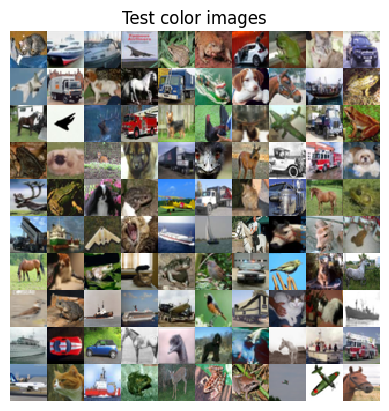

In [ ]:
#Display first 100 input images

imgs = X_test[:100]
imgs = imgs.reshape((10,10,img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

In [ ]:
#Convert color train and test images to gray

X_train_gray = rgb2gray(X_train)
X_test_gray = rgb2gray(X_test)

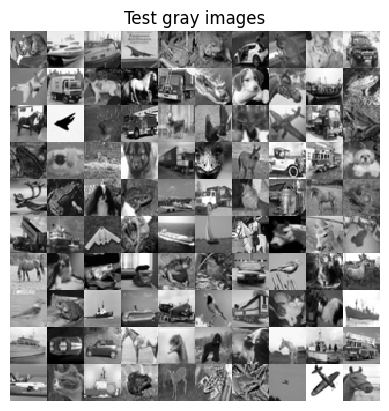

In [ ]:
#Display gray verison of images

imgs = X_test_gray[:100]
imgs = imgs.reshape((10,10,img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [ ]:
#Normalize output train and test color images

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [ ]:
#Normalize input train and test gray images

X_train_gray = X_train_gray.astype('float') / 255
X_test_gray = X_test_gray.astype('float32') / 255

In [ ]:
#Reshape images

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, channels)

X_train_gray = X_train_gray.reshape(X_train_gray.shape[0], img_rows, img_cols, 1)
X_test_gray = X_test_gray.reshape(X_test_gray.shape[0], img_rows, img_cols, 1)

In [ ]:
#Network parameters

input_shape = (img_rows, img_cols, 1)
kernel_size=3
batch_size=32
latent_dim=256
layer_filters=[64,128, 256]

In [ ]:
#Build autoencoder model

inputs = Input(shape=input_shape, name='encoder_input')
X = inputs
for filters in layer_filters:
  X = Conv2D(filters=filters,
             kernel_size=kernel_size,
             strides=2,
             activation='relu',
             padding='same')(X)

In [ ]:
#Shape info

shape = K.int_shape(X)
X = Flatten()(X)
latent = Dense(latent_dim, name='latent_vector')(X)

In [ ]:
#Instantiate encoder model

encoder = Model(inputs, latent, name='encoder')
encoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1418496 (5.41 MB)
Trainable params: 1418496 (

In [ ]:
#Build decoder model

latent_inputs = Input(shape=(latent_dim), name='decoder_input')
X = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
X = Reshape((shape[1], shape[2], shape[3]))(X)

In [ ]:
for filters in layer_filters[::-1]:
  X = Conv2DTranspose(filters=filters,
                      kernel_size=kernel_size,
                      strides=2,
                      activation='relu',
                      padding='same')(X)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(X)

In [ ]:
#Instantiate decoder model

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         590080    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 64)        7379

In [ ]:
autoencoder = Model(inputs, decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               1418496   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3431811 (13.09 MB)
Trainable params: 3431811 (13.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Prepare model saving directory

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_autoencoder_model.h5'
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [ ]:
#Reduce learning rate

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

In [ ]:
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

In [ ]:
#Model compile

autoencoder.compile(loss='mse', optimizer='adam')

In [ ]:
callbacks = [lr_reducer, checkpoint]

In [ ]:
#Model training

autoencoder.fit(X_train_gray,
                X_train,
                validation_data=(X_test_gray, X_test),
                epochs=30,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/30
1562/1563 [============================>.] - ETA: 0s - loss: 0.0038
Epoch 1: val_loss did not improve from 0.00744
1563/1563 [==============================] - 24s 15ms/step - loss: 0.0038 - val_loss: 0.0078 - lr: 1.0000e-05
Epoch 2/30
1558/1563 [============================>.] - ETA: 0s - loss: 0.0038
Epoch 2: val_loss did not improve from 0.00744
1563/1563 [==============================] - 15s 10ms/step - loss: 0.0038 - val_loss: 0.0078 - lr: 1.0000e-05
Epoch 3/30
1561/1563 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 3: val_loss did not improve from 0.00744
1563/1563 [==============================] - 15s 10ms/step - loss: 0.0037 - val_loss: 0.0078 - lr: 1.0000e-05
Epoch 4/30
1559/1563 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 4: val_loss did not improve from 0.00744
1563/1563 [==============================] - 15s 10ms/step - loss: 0.0037 - val_loss: 0.0078 - lr: 1.0000e-05
Epoch 5/30
1562/1563 [============================>.] - 

In [ ]:
X_decoded = autoencoder.predict(X_test_gray)

313/313 [==============================] - 1s 4ms/step


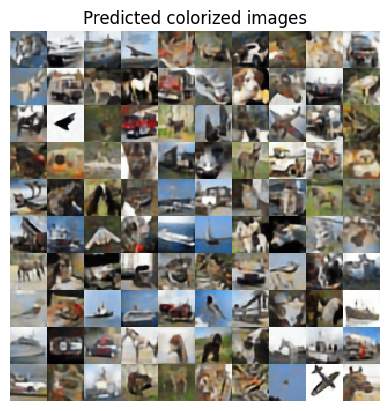

In [ ]:
#Display the first 100 colorized images

imgs = X_decoded[:100]
imgs = imgs.reshape((10,10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Predicted colorized images')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()